In [1]:
import sys
sys.path.append('../code/')

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from matplotlib import pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import pacf, acf

from plot_utils import preprocess_df, plot_store_charts, plot_folds
from test_utils import run_stat_test
from sm_utils import compute_pacf_acf, StatmodelsWrapper, run_k_fold_tain_val_statmodels

%matplotlib inline

In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

# Upload data

In [2]:
STORE_ID = 1

In [3]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
store = pd.read_csv('../data/store.csv')
sample_sublission = pd.read_csv('../data/sample_submission.csv')

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Observation

In [4]:
train = preprocess_df(train)
test = preprocess_df(test)

train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,NSales
1017208,1115,2,2013-01-01,0,0,0,0,a,1,0.000000
1016473,379,2,2013-01-01,0,0,0,0,a,1,0.000000
1016472,378,2,2013-01-01,0,0,0,0,a,1,0.000000
1016471,377,2,2013-01-01,0,0,0,0,a,1,0.000000
1016470,376,2,2013-01-01,0,0,0,0,a,1,0.000000
...,...,...,...,...,...,...,...,...,...,...
745,746,5,2015-07-31,9082,638,1,1,0,1,0.218575
746,747,5,2015-07-31,10708,826,1,1,0,1,0.257707
747,748,5,2015-07-31,7481,578,1,1,0,1,0.180044
741,742,5,2015-07-31,10460,1016,1,1,0,1,0.251739


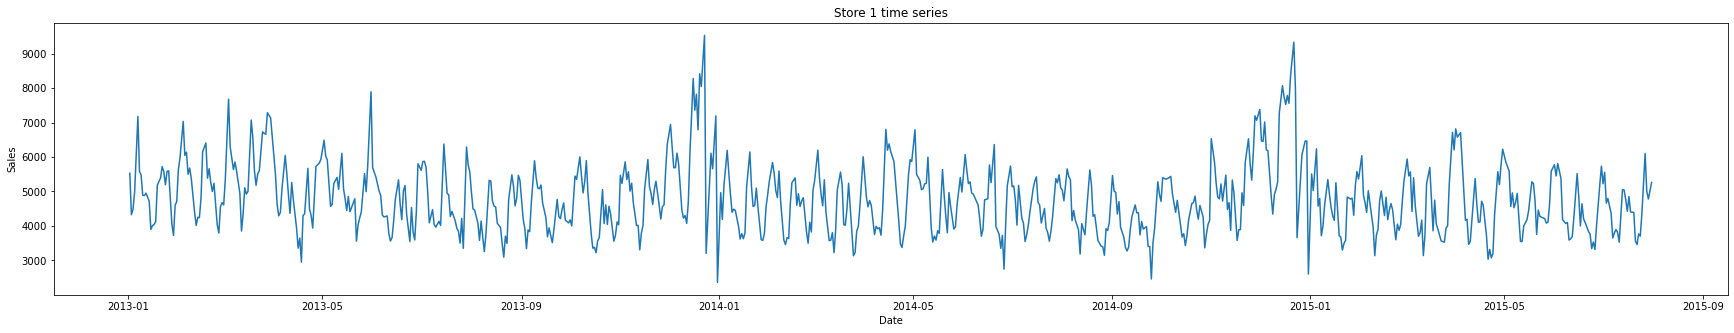

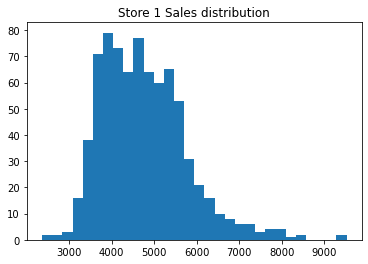

In [5]:
plot_store_charts(train , STORE_ID)

In [6]:
store_ts = train[(train['Store'] == STORE_ID) & (train['Open'] == 1)].reset_index(drop=True)

# Train/Test splitting

In [7]:
test_file_period = test.loc[test['Store'] == STORE_ID, 'Date'].max() - test.loc[test['Store'] == STORE_ID, 'Date'].min()
train_file_period = store_ts['Date'].max() - store_ts['Date'].min()
print(f"Test file period {test_file_period}\nTrain file period {train_file_period}")

Test file period 47 days 00:00:00
Train file period 940 days 00:00:00


In [8]:
fold_ids = list(TimeSeriesSplit(test_size=47).split(store_ts))

# Trim start in order to have same size folds
train_fold_len = min([len(el[0]) for el in fold_ids])
for i in range(len(fold_ids)):
    fold_ids[i] = (fold_ids[i][0][-train_fold_len:], fold_ids[i][1])

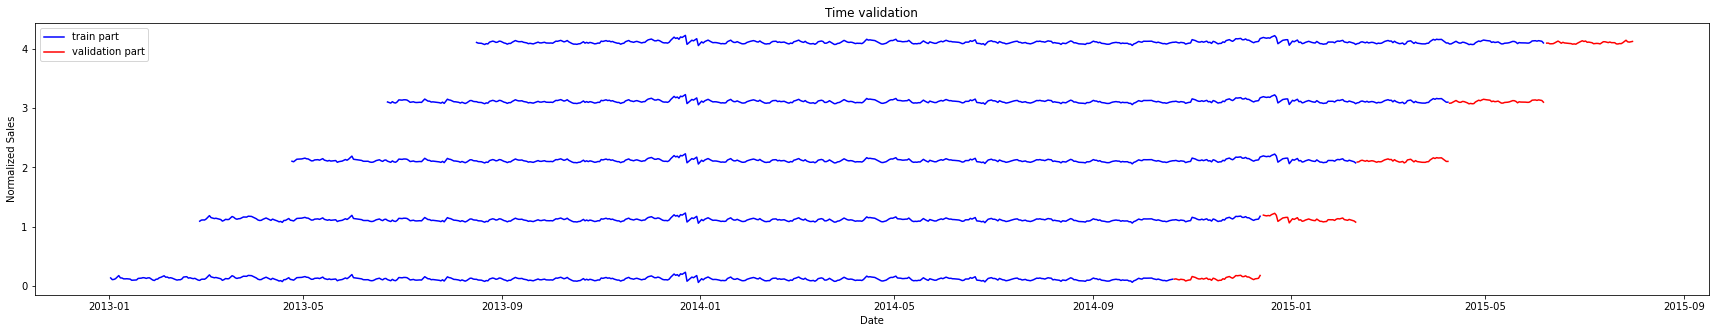

In [9]:
plot_folds(store_ts, fold_ids)

# Checks for Stationarity

In [10]:
test_results = {}
test_results.update(run_stat_test(store_ts['Sales'], adfuller))
test_results.update(run_stat_test(store_ts['Sales'], kpss, 3))

pd.Series(test_results)

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


adfuller_statistics           -5.399623
adfuller_p_value               0.000003
adfuller_critical_value_1%    -3.438905
adfuller_critical_value_5%    -2.865316
adfuller_critical_value_10%   -2.568781
kpss_statistics                0.231998
kpss_p_value                   0.100000
kpss_critical_value_10%        0.347000
kpss_critical_value_5%         0.463000
kpss_critical_value_2.5%       0.574000
kpss_critical_value_1%         0.739000
dtype: float64

# ARMA

==== Fold 0 Starting


../code/sm_utils.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_train['Sales'] = standart_norm.transform(fold_train['Sales'].values[:,None])[:,0]
../code/sm_utils.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_val['Sales'] = standart_norm.transform(fold_val['Sales'].values[:,None])[:,0]


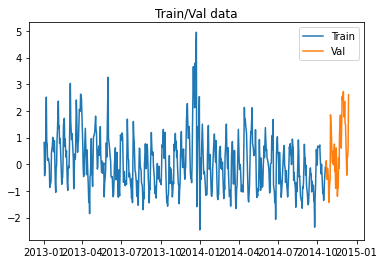

Residual ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


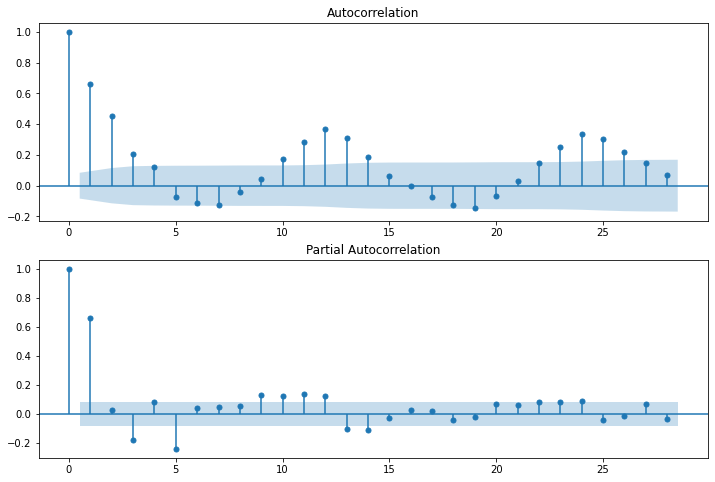

Residual ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


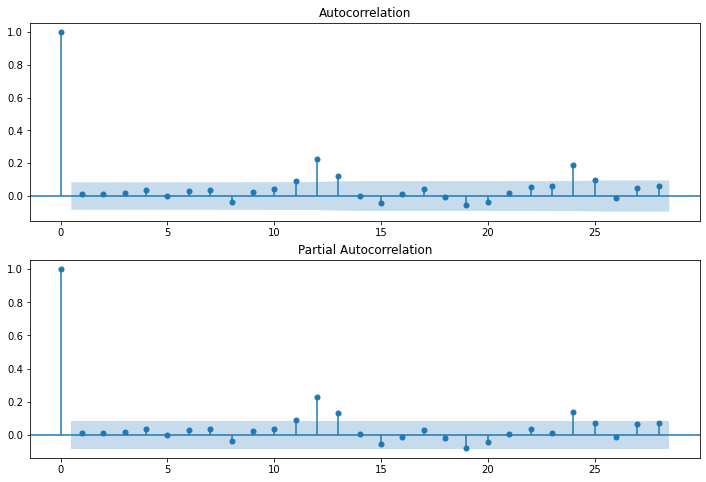

100%|██████████| 47/47 [00:18<00:00,  2.55it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  593
Model:                 ARIMA(5, 0, 2)   Log Likelihood                -617.952
Date:                Mon, 15 Feb 2021   AIC                           1253.904
Time:                        13:03:48   BIC                           1293.370
Sample:                             0   HQIC                          1269.275
                                - 593                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.079      0.022      0.983      -0.154       0.157
ar.L1          0.5172      0.169      3.059      0.002       0.186       0.849
ar.L2          0.0862      0.153      0.565      0.5


../code/sm_utils.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_train['Sales'] = standart_norm.inverse_transform(fold_train['Sales'].values[:,None])[:,0]
../code/sm_utils.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_val['Sales'] = standart_norm.inverse_transform(fold_val['Sales'].values[:,None])[:,0]


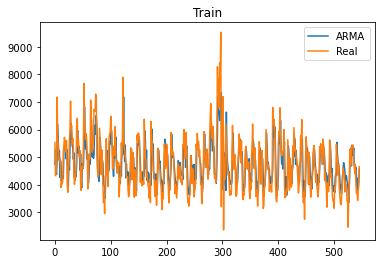

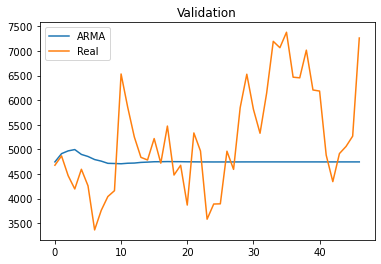

==== Fold 0 Completed
==== Fold 1 Starting


../code/sm_utils.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_train['Sales'] = standart_norm.transform(fold_train['Sales'].values[:,None])[:,0]
../code/sm_utils.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_val['Sales'] = standart_norm.transform(fold_val['Sales'].values[:,None])[:,0]


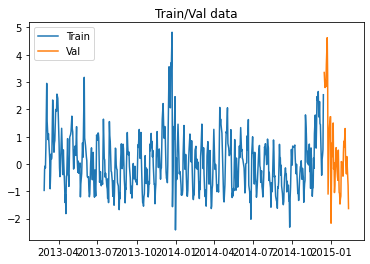

Residual ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


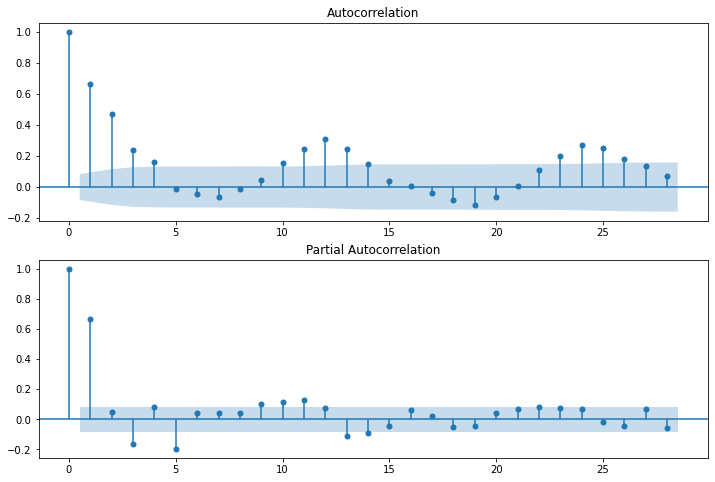

Residual ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


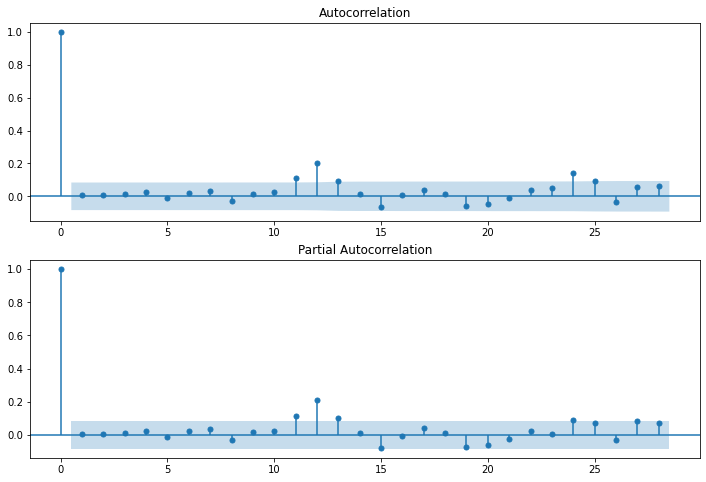

100%|██████████| 47/47 [00:20<00:00,  2.32it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  593
Model:                 ARIMA(5, 0, 2)   Log Likelihood                -616.192
Date:                Mon, 15 Feb 2021   AIC                           1250.384
Time:                        13:04:09   BIC                           1289.851
Sample:                             0   HQIC                          1265.756
                                - 593                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0050      0.088      0.057      0.955      -0.167       0.177
ar.L1          0.4507      0.211      2.140      0.032       0.038       0.863
ar.L2          0.0860      0.166      0.518      0.6


../code/sm_utils.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_train['Sales'] = standart_norm.inverse_transform(fold_train['Sales'].values[:,None])[:,0]
../code/sm_utils.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_val['Sales'] = standart_norm.inverse_transform(fold_val['Sales'].values[:,None])[:,0]


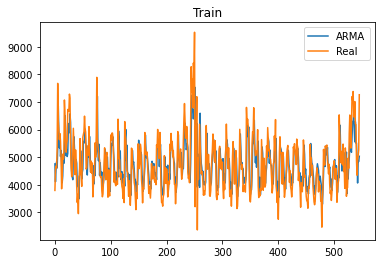

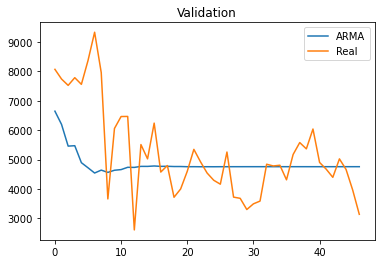

../code/sm_utils.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_train['Sales'] = standart_norm.transform(fold_train['Sales'].values[:,None])[:,0]
../code/sm_utils.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_val['Sales'] = standart_norm.transform(fold_val['Sales'].values[:,None])[:,0]


==== Fold 1 Completed
==== Fold 2 Starting


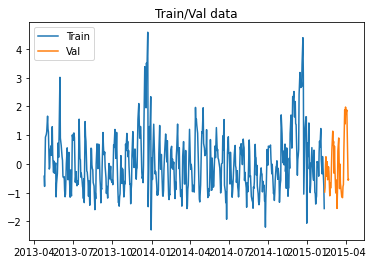

Residual ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


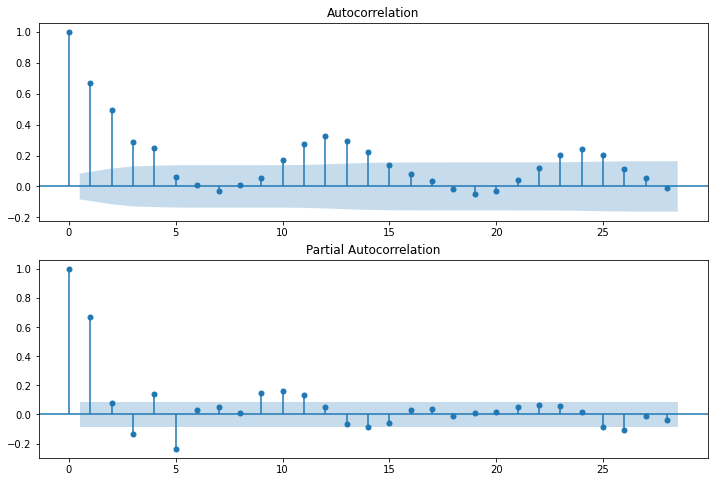

Residual ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


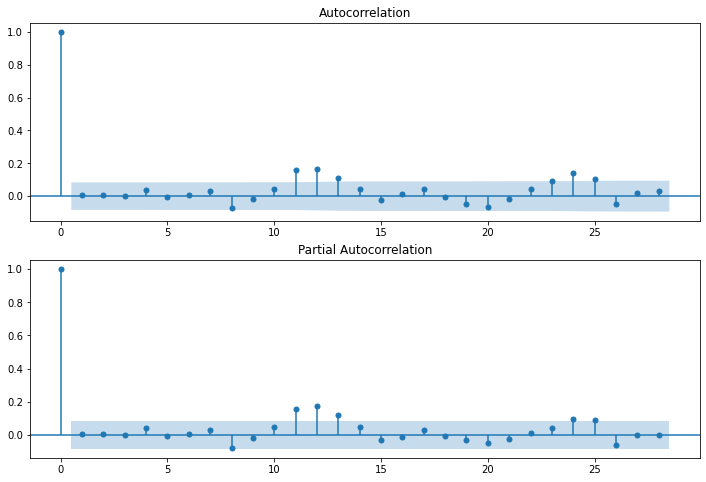

100%|██████████| 47/47 [00:15<00:00,  3.09it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  593
Model:                 ARIMA(5, 0, 2)   Log Likelihood                -608.652
Date:                Mon, 15 Feb 2021   AIC                           1235.304
Time:                        13:04:26   BIC                           1274.770
Sample:                             0   HQIC                          1250.675
                                - 593                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0068      0.100     -0.068      0.946      -0.202       0.189
ar.L1          0.3313      0.197      1.685      0.092      -0.054       0.717
ar.L2          0.0800      0.126      0.634      0.5


../code/sm_utils.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_train['Sales'] = standart_norm.inverse_transform(fold_train['Sales'].values[:,None])[:,0]
../code/sm_utils.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_val['Sales'] = standart_norm.inverse_transform(fold_val['Sales'].values[:,None])[:,0]


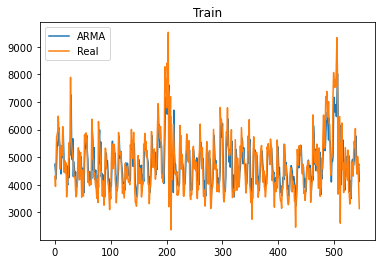

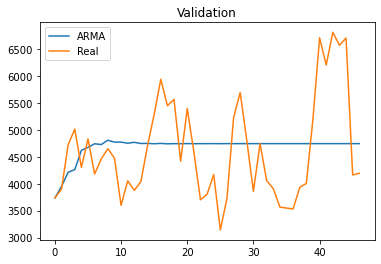

../code/sm_utils.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_train['Sales'] = standart_norm.transform(fold_train['Sales'].values[:,None])[:,0]
../code/sm_utils.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_val['Sales'] = standart_norm.transform(fold_val['Sales'].values[:,None])[:,0]


==== Fold 2 Completed
==== Fold 3 Starting


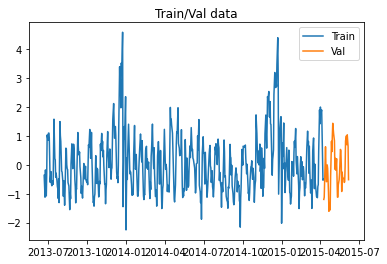

Residual ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


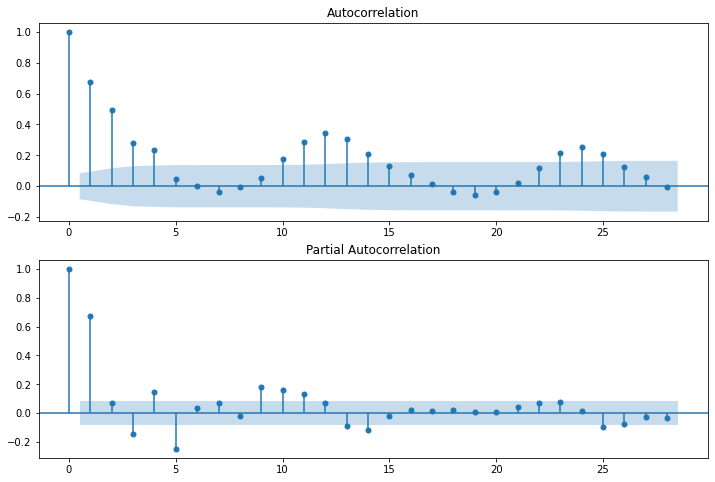

Residual ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


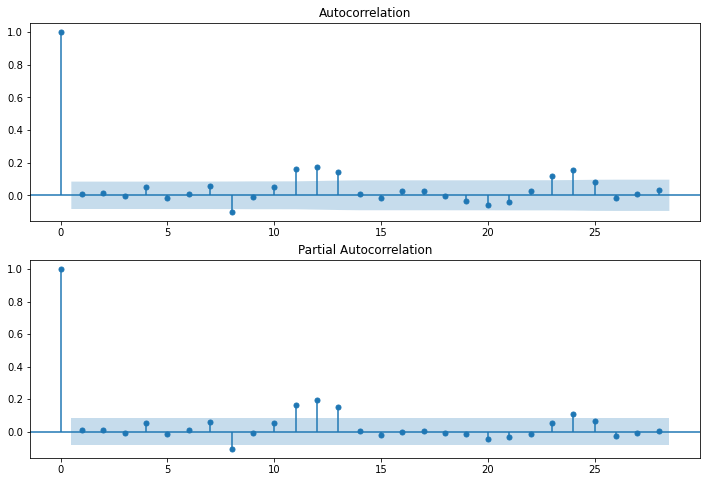

100%|██████████| 47/47 [00:19<00:00,  2.46it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  593
Model:                 ARIMA(5, 0, 2)   Log Likelihood                -601.593
Date:                Mon, 15 Feb 2021   AIC                           1221.186
Time:                        13:04:46   BIC                           1260.653
Sample:                             0   HQIC                          1236.558
                                - 593                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0038      0.100     -0.038      0.970      -0.199       0.192
ar.L1         -0.0557      0.153     -0.365      0.715      -0.355       0.244
ar.L2          0.1066      0.088      1.218      0.2


../code/sm_utils.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_train['Sales'] = standart_norm.inverse_transform(fold_train['Sales'].values[:,None])[:,0]
../code/sm_utils.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_val['Sales'] = standart_norm.inverse_transform(fold_val['Sales'].values[:,None])[:,0]


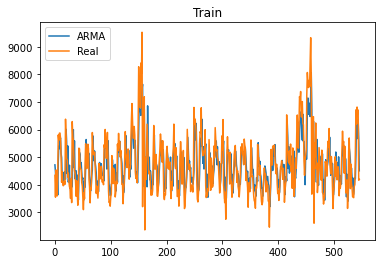

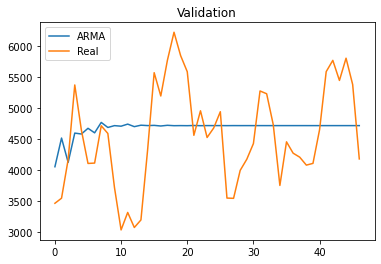

../code/sm_utils.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_train['Sales'] = standart_norm.transform(fold_train['Sales'].values[:,None])[:,0]
../code/sm_utils.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_val['Sales'] = standart_norm.transform(fold_val['Sales'].values[:,None])[:,0]


==== Fold 3 Completed
==== Fold 4 Starting


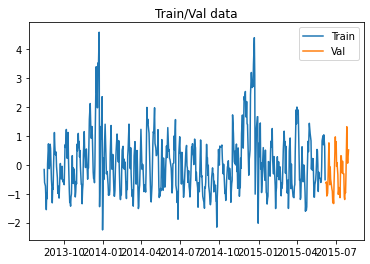

Residual ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


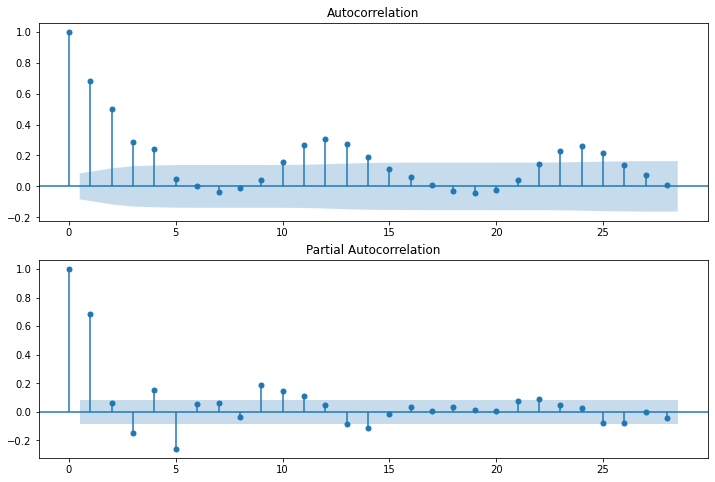

Residual ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


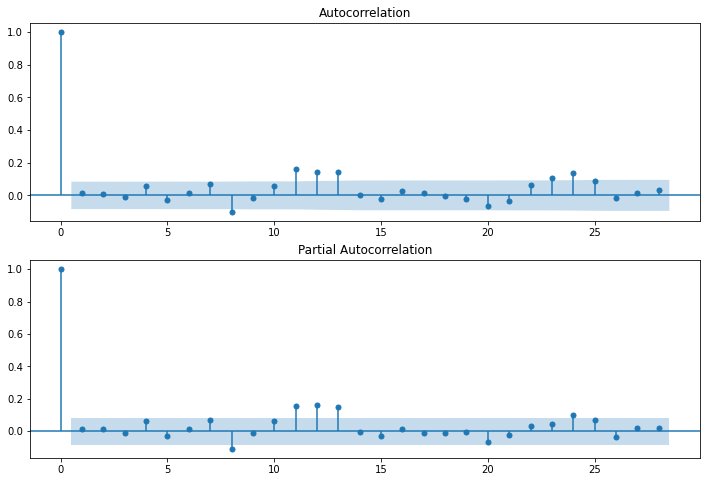

100%|██████████| 47/47 [00:19<00:00,  2.36it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  593
Model:                 ARIMA(5, 0, 2)   Log Likelihood                -591.175
Date:                Mon, 15 Feb 2021   AIC                           1200.350
Time:                        13:05:07   BIC                           1239.817
Sample:                             0   HQIC                          1215.722
                                - 593                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.101     -0.025      0.980      -0.200       0.195
ar.L1         -0.0953      0.123     -0.775      0.438      -0.336       0.146
ar.L2          0.0950      0.073      1.296      0.1


../code/sm_utils.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_train['Sales'] = standart_norm.inverse_transform(fold_train['Sales'].values[:,None])[:,0]
../code/sm_utils.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_val['Sales'] = standart_norm.inverse_transform(fold_val['Sales'].values[:,None])[:,0]


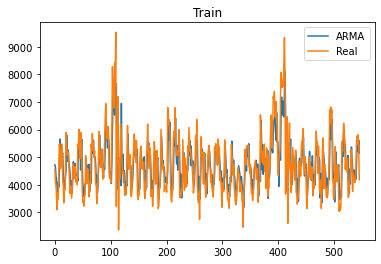

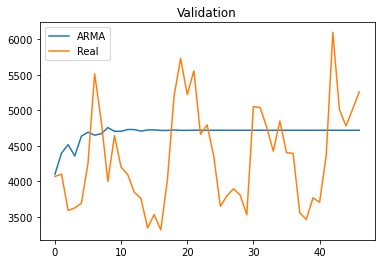

==== Fold 4 Completed


In [11]:
cv_results = run_k_fold_tain_val_statmodels(store_ts, fold_ids, [(5,0,2) for _ in range(5)], mean_absolute_error)

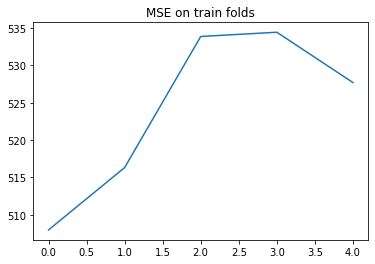

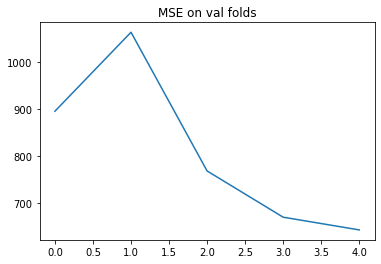

Mean Train Score: 524.0540727527487
Std Train score: 10.340432780165525
Mean Test score: 808.2282662641229
Std test score: 155.81578155047956


In [20]:
plt.title("MSE on train folds")
plt.plot(cv_results['train_scores'])
plt.show()

plt.title("MSE on val folds")
plt.plot(cv_results['val_scores'])
plt.show()

print("Mean Train Score: {}\nStd Train score: {}\nMean Test score: {}\nStd test score: {}".format(
    np.mean(cv_results['train_scores']),
    np.std(cv_results['train_scores']),
    np.mean(cv_results['val_scores']),
    np.std(cv_results['val_scores'])
))